### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imageio import imread

sns.set_theme(style="darkgrid")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Loading Images
- Class 1 is the True class - images of ships that are centered in the satellite image
- Class 0 is the False class - images of random land cover that do not include ships or partially include ships

In [3]:
# Path to dataset
IMG_DIR = 'shipsnet'
class1 = []
class0 = []
for file in os.listdir(IMG_DIR):
    loaded_img = imread(os.path.join(IMG_DIR, file))
    if file[0] == '0':
        class0.append(loaded_img)
    else:
        class1.append(loaded_img)
class1 = np.array(class1)
class0 = np.array(class0)

print(f"Class 1 shape: {class1.shape}")
print(f"Class 0 shape: {class0.shape}")

/var/folders/z2/k1ddzt7d0q32_935myb4fz300000gn/T/ipykernel_94566/3465661851.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  loaded_img = imread(os.path.join(IMG_DIR, file))


Class 1 shape: (1000, 80, 80, 3)
Class 0 shape: (3000, 80, 80, 3)


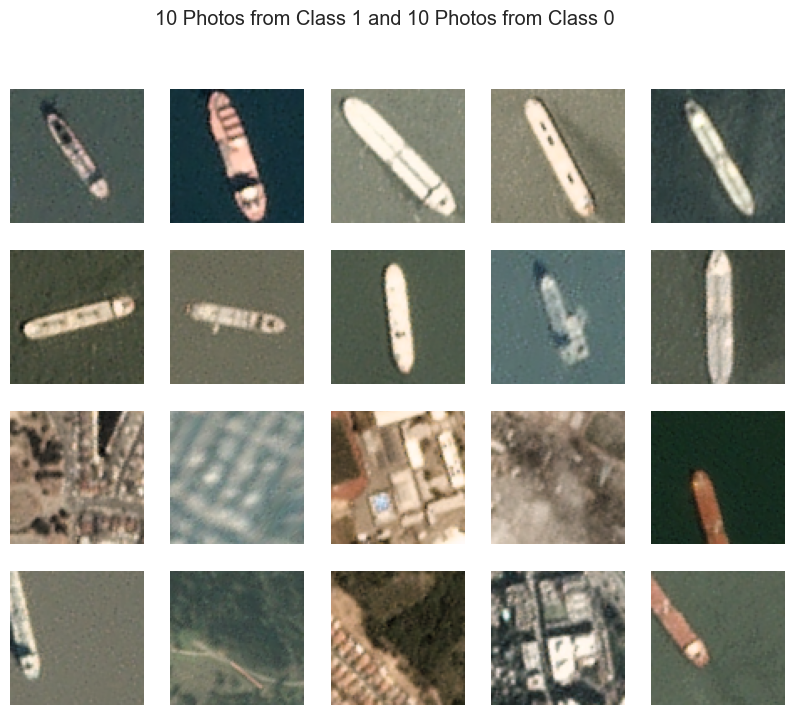

In [4]:
# TODO: clean up plot
np.random.seed = 888

fig, axs = plt.subplots(4, 5, figsize=(10, 8))
class1_sample = np.random.choice(range(len(class1)), 10, replace=False)
class0_sample = np.random.choice(range(len(class0)), 10, replace=False)

for idx, img in enumerate(class1[class1_sample]):
    axs[idx % 2][idx % 5].imshow(img)
    axs[idx % 2][idx % 5].axis('off')

for idx, img in enumerate(class0[class0_sample]):
    axs[idx % 2 + 2][idx % 5].imshow(img)
    axs[idx % 2 + 2][idx % 5].axis('off')
plt.suptitle("10 Photos from Class 1 and 10 Photos from Class 0")
plt.show()

### General Thoughts
- Since orientation of ships varies significantly, a model that detects edges (CNNs) is likely to be a lot more performant than, e.g. logistic regression
- Noise in images - may benefit from some kind of noise reduction technique as a part of the model prediction pipeline?
    - Median filter (also called median blur) may be helpful @ noise reduction
        - need to determine window size
    - How would we implement?
        - Need to create a wrapper if we wanted to apply it @ inference for sklearn?
        - Can add as layer in TF model
- Images appear to be at differing contrasts, potentially due to cloud cover, time of day, air pollution, etc.
    - Image augmentation that varies brightness and contrast will probably be really helpful
    - Would varying saturation help?
- Images feature ships in different orientations
    - Image augmentation that reorients images (random rotate? tf.image.rot90?) will probably be helpful
- Other geometric image augmentation techniques like shearing, rotating, cropping, etc. don't seem applicable since our True class is photos where the ship is centered (e.g. if we crop an image w/ class 1, we'd end up with a ship that's no longer centered and may be cut off which should actually be interpreted as class 0)

# Data Augmentation

### Applying Median Blur

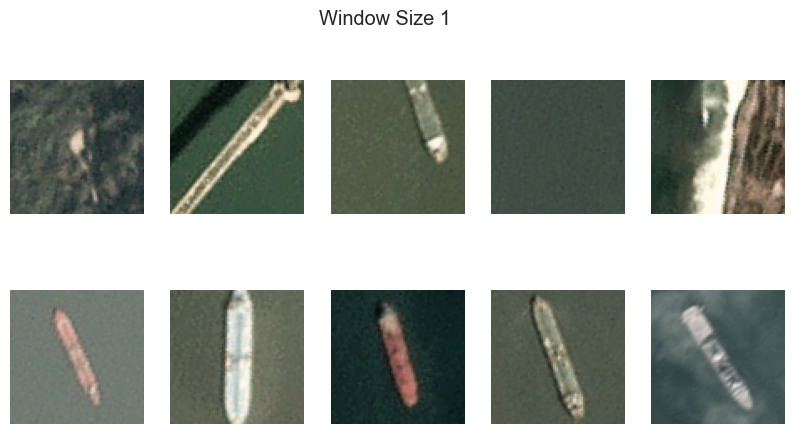

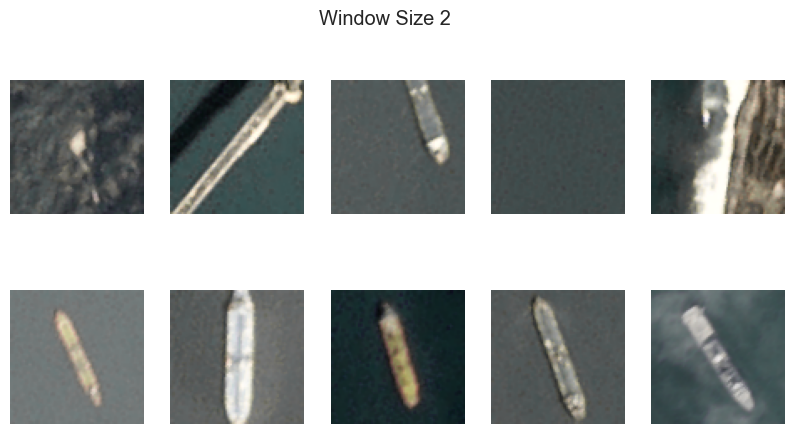

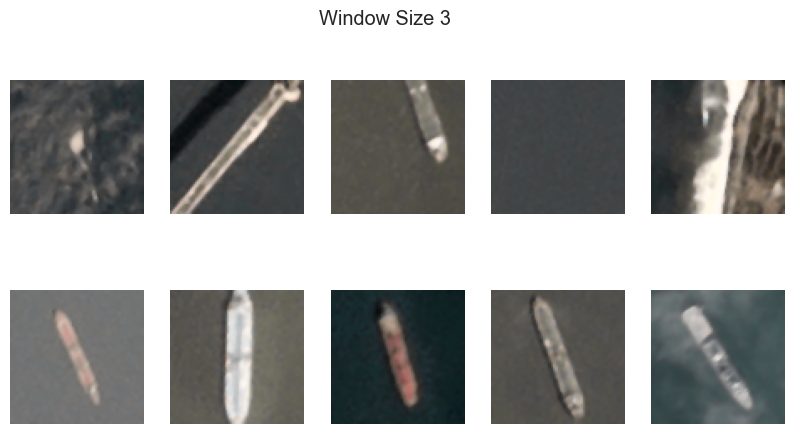

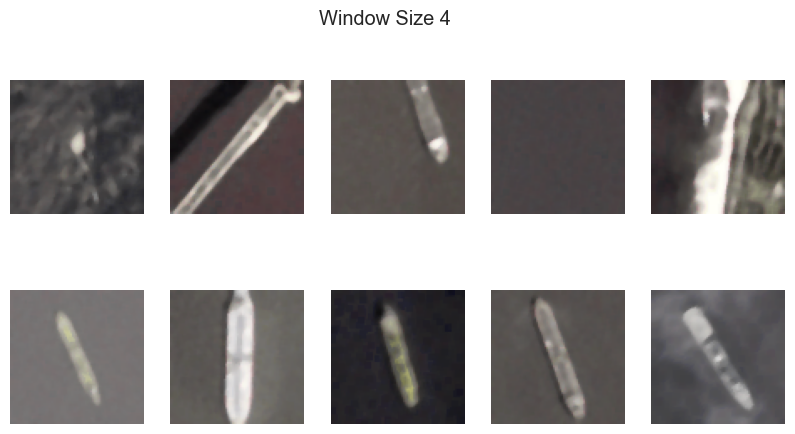

In [5]:
from scipy.ndimage import median_filter

# Function to apply median filtering to images
def apply_median_filter(image, window_size=3): # Window size is set to 3.
    filtered_image = median_filter(image, size=window_size)
    return filtered_image

np.random.seed = 888
class0_sample = class0[np.random.choice(range(len(class0)), 5)]
class1_sample = class1[np.random.choice(range(len(class1)), 5)]

for window_size in [1, 2, 3, 4]:
    class0_sample_filtered = np.array([apply_median_filter(img, window_size) for img in class0_sample])
    class1_sample_filtered = np.array([apply_median_filter(img, window_size) for img in class1_sample])
    
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))

    for idx, img in enumerate(class0_sample_filtered):
        axs[0][idx].imshow(img)
        axs[0][idx].axis('off')

    for idx, img in enumerate(class1_sample_filtered):
        axs[1][idx].imshow(img)
        axs[1][idx].axis('off')
    plt.suptitle(f"Window Size {window_size}")
    plt.show()

Window size 4 appears to begin to remove salient features in the images so it's probably too extreme. Window Sizes 2 and 3 appear to perform best for removing noise. We'll proceed with window size 2 and re-evaluate if the model underperforms.

In [6]:
# Applying median filtering to images
class1_filtered = np.array([apply_median_filter(img, 2) for img in class1])
class0_filtered = np.array([apply_median_filter(img, 2) for img in class0])

# Concatenating filtered images
X = np.concatenate((class1_filtered, class0_filtered), axis=0)
y = np.concatenate((np.ones(class1.shape[0]), np.zeros(class0.shape[0])), axis=0)

### Defining Augmented Image Generator

In [7]:
import numpy as np
import os
from imageio import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
# Performing Data augmentation using ImageDataGenerator
# Data augmentation to improve generalization

# define preprocessing function to randomly adjust saturation and contrast
# these are not available by default in ImageDataGenerator
def apply_random_effects(img):
    img = tf.image.random_contrast(
        image = img, lower = 0.8, upper = 1.2, 
        seed = 888
    )
    img = tf.image.random_saturation(
        image = img, lower = 0.8, upper = 1.2,
        seed = 888)
    img = tf.image.random_brightness(
        image = img, max_delta = 0.2, seed = 888
    )
    return img

datagen = ImageDataGenerator(
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function = apply_random_effects
)

# Splitting Data

In [8]:
# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Normalizing pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Experimenting using different Learning Rates in order to arrive at the model with best validating accuracy

Training model with learning rate: 0.01


2024-04-01 07:33:37.840890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:33:44.054060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:33:50.229788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:33:56.409367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:34:02.639416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Training model with learning rate: 0.001


2024-04-01 07:34:09.600229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:34:15.954647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:34:22.083837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:34:28.163812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:34:34.268035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Training model with learning rate: 0.0001


2024-04-01 07:34:41.053435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:34:47.259506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:34:53.335659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:34:59.438999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:35:05.516004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Training model with learning rate: 1e-05


2024-04-01 07:35:12.283433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:35:18.364117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:35:24.508876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:35:30.574285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-01 07:35:36.621037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


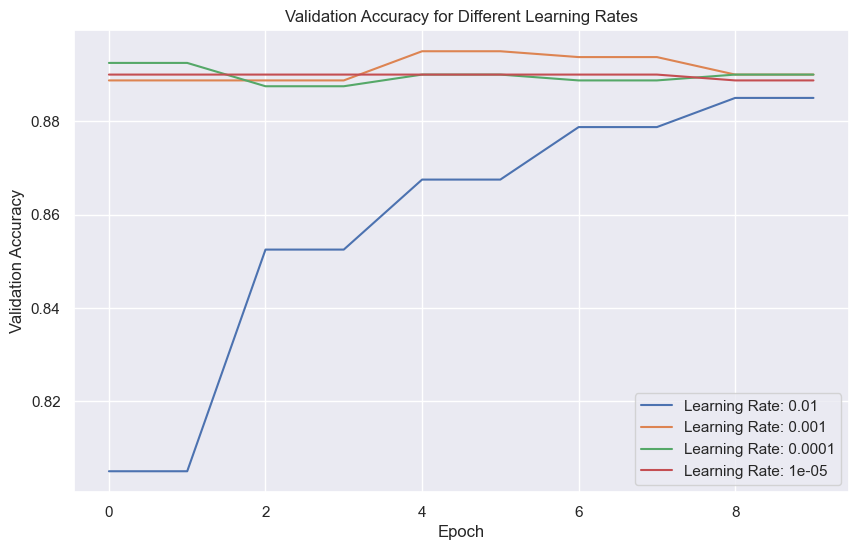

In [32]:

# Model training
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])



# Define different learning rates to experiment with
learning_rates = [0.01, 0.001, 0.0001, 0.00001]

# Train the model with different learning rates
history_list = []
for learning_rate in learning_rates:
    print(f"Training model with learning rate: {learning_rate}")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train) // 32, epochs=10, validation_data=(X_test, y_test),
                        verbose=0)
    history_list.append(history)

# Plot training history for each learning rate
plt.figure(figsize=(10, 6))
for i, learning_rate in enumerate(learning_rates):
    plt.plot(history_list[i].history['val_accuracy'], label=f'Learning Rate: {learning_rate}')

plt.title('Validation Accuracy for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

## Developing Model with 5 Epochs and 0.00001 learning rate

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.7361 - loss: 0.6630 - val_accuracy: 0.7513 - val_loss: 0.5772
Epoch 2/5


2024-04-01 07:40:28.659871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7513 - val_loss: 0.5772
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7580 - loss: 0.5701 - val_accuracy: 0.7513 - val_loss: 0.5339
Epoch 4/5


2024-04-01 07:40:35.043674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7513 - val_loss: 0.5339
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7721 - loss: 0.5182 - val_accuracy: 0.7513 - val_loss: 0.5032
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7366 - loss: 0.5162
Test Accuracy: 0.7425000071525574


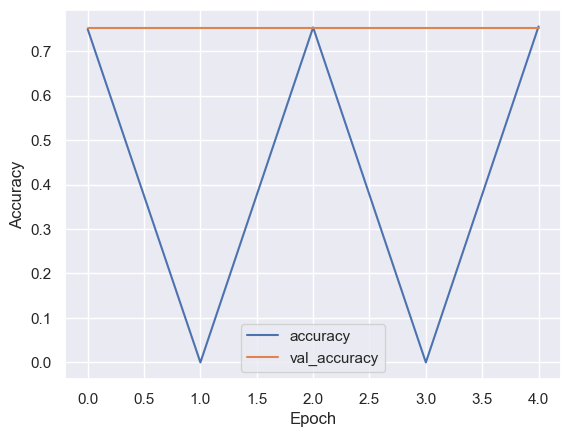

In [34]:

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32, epochs=5, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Plot training history

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model appears to be performing really well as testing accuracy is higher than training accuracy. The data augmentation process helped reduce generalization.

## Developing Model using 5 epochs and 0.0001 learning rate

Epoch 1/5


2024-04-02 18:34:17.969975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


75/75 [==============================] - 7s 88ms/step - loss: 0.4683 - accuracy: 0.7812 - val_loss: 0.3380 - val_accuracy: 0.8425
Epoch 2/5
75/75 [==============================] - 9s 115ms/step - loss: 0.2963 - accuracy: 0.8800 - val_loss: 0.2544 - val_accuracy: 0.8788
Epoch 3/5
75/75 [==============================] - 8s 102ms/step - loss: 0.2087 - accuracy: 0.9192 - val_loss: 0.2559 - val_accuracy: 0.8838
Epoch 4/5
75/75 [==============================] - 7s 98ms/step - loss: 0.1807 - accuracy: 0.9283 - val_loss: 0.1902 - val_accuracy: 0.9125
Epoch 5/5
25/25 [==============================] - 1s 22ms/step - loss: 0.1673 - accuracy: 0.9275
Test Accuracy: 0.9275000095367432


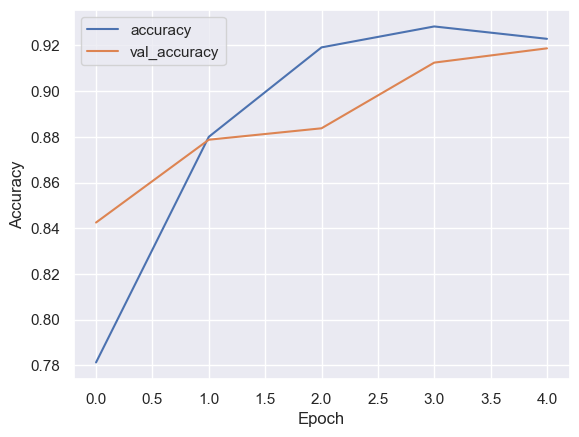

In [45]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=5, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Plot training history

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model with 0.0001 learninig rate and 5 epoch performs even better than the model with 0.00001 learning rate and 5 epochs, we can use this model as our best model.

## Prediction Function

In [20]:
def make_predictions(model, data):

    # Making predictions
    predictions = model.predict(data)

    # Converting predictions to binary labels (0 or 1)
    predictions = (predictions > 0.5).astype(int)

    return predictions


## Confusion Matrix

25/25 [==============================] - 1s 36ms/step


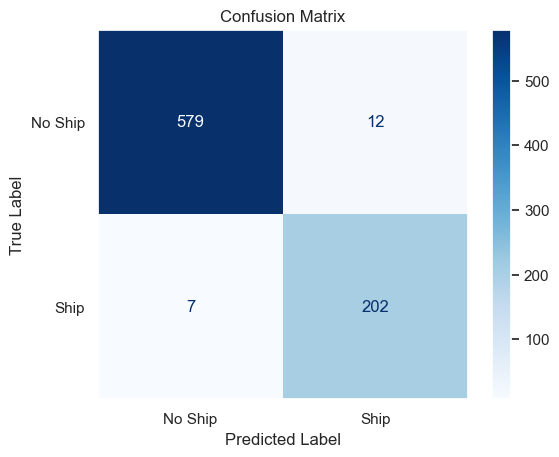

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(pred_labels, true_labels, title):
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Ship', 'Ship'])
    disp.plot(cmap='Blues')
    plt.grid(False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

predictions = make_predictions(model,X_test)
plot_confusion_matrix(
    pred_labels = predictions,
    true_labels = y_test,
    title="Confusion Matrix"
)

## The Baseline Model (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Flattening the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initializing and training the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test_flat)

# Calculating test accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


Random Forest Accuracy: 0.95375


The baseline model outperforms the CNN model. We can fine-tune the hyper-parameters of our model even further to get a higher test accuracy.  

In [ ]:
X_test.shape

(800, 80, 80, 3)

In [ ]:
X_train.shape

(2400, 80, 80, 3)

In [ ]:
X_val.shape

(800, 80, 80, 3)

## Using Assignment 10 Model Architecture to develop our model

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1',
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 80, 80, 3))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 80, 80, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 40, 40, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 1024)           │    26,215,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,270,145 (100.21 MB)

 Trainable params: 26,270,145 (100.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy'])

In [ ]:
# set random seed to get reproductible results
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
import numpy as np
tf.random.set_seed(1234)
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val)
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.7896 - loss: 0.5552 - val_accuracy: 0.8975 - val_loss: 0.2280
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.9091 - loss: 0.2176 - val_accuracy: 0.9175 - val_loss: 0.1951
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.9282 - loss: 0.1783 - val_accuracy: 0.9388 - val_loss: 0.1510
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.9454 - loss: 0.1368 - val_accuracy: 0.9375 - val_loss: 0.1520
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.9536 - loss: 0.1175 - val_accuracy: 0.9013 - val_loss: 0.2658
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.9513 - loss: 0.1446 - val_accuracy: 0.9425 - val_loss: 0.1544
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.9710 - loss: 0.0890 - val_accuracy: 0.9737 - val_loss: 0.1007
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.9757 - loss: 0.0777 - val_accu

In [ ]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9700 - loss: 0.0720
Test Accuracy: 0.9737499952316284


The model built using assignment 10 model architecture and our data augmentation methods appears to be doing pretty well. 

* Training accuracy: 99.02%
* Validation accuracy: 98%
* Test accuracy: 97%

Model is not overfitting

## Confusion Matrix

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


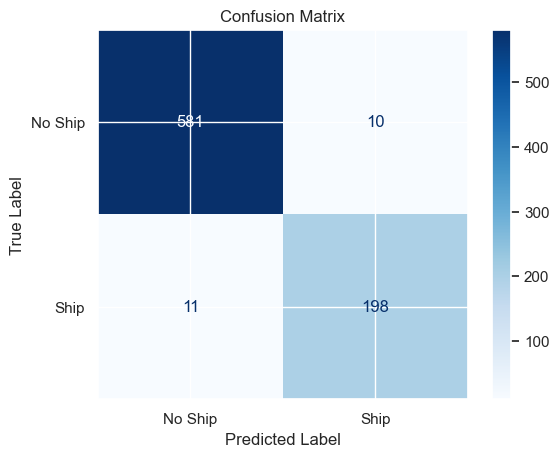

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = make_predictions(model,X_test)
plot_confusion_matrix(
    pred_labels = predictions,
    true_labels = y_test,
    title="Confusion Matrix"
)

## Decreasing Conv2D 2nd Layer Kernel size to 3 and the number of dense neurons by half (The Final Model)

In [14]:
import tensorflow as tf
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=1024//2,
    name='fc_1',
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 80, 80, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 80, 80, 32)        2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 40, 40, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 40, 40, 64)        18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 20, 20, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 fc_1 (Dense)                (None, 512)               13107712  
                                                                 
 dropout_1 (Dropout)         (None, 512)              

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
    metrics=['accuracy'])

In [16]:
# set random seed to get reproductible results
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
import numpy as np
tf.random.set_seed(1234)
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    batch_size=32,
    epochs=15,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 32
)

Epoch 1/15


2024-04-02 18:55:12.911740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


75/75 [==============================] - 9s 119ms/step - loss: 0.4341 - accuracy: 0.8217 - val_loss: 0.3315 - val_accuracy: 0.8625
Epoch 2/15
75/75 [==============================] - 12s 165ms/step - loss: 0.2567 - accuracy: 0.8975 - val_loss: 0.2028 - val_accuracy: 0.8938
Epoch 3/15
75/75 [==============================] - 9s 116ms/step - loss: 0.2154 - accuracy: 0.9087 - val_loss: 0.1928 - val_accuracy: 0.9125
Epoch 4/15
75/75 [==============================] - 8s 110ms/step - loss: 0.1938 - accuracy: 0.9192 - val_loss: 0.2017 - val_accuracy: 0.9062
Epoch 5/15
75/75 [==============================] - 12s 153ms/step - loss: 0.1639 - accuracy: 0.9292 - val_loss: 0.1540 - val_accuracy: 0.9325
Epoch 6/15
75/75 [==============================] - 16s 210ms/step - loss: 0.1421 - accuracy: 0.9417 - val_loss: 0.1374 - val_accuracy: 0.9463
Epoch 7/15
75/75 [==============================] - 15s 195ms/step - loss: 0.1342 - accuracy: 0.9488 - val_loss: 0.1213 - val_accuracy: 0.9400
Epoch 8/15
75

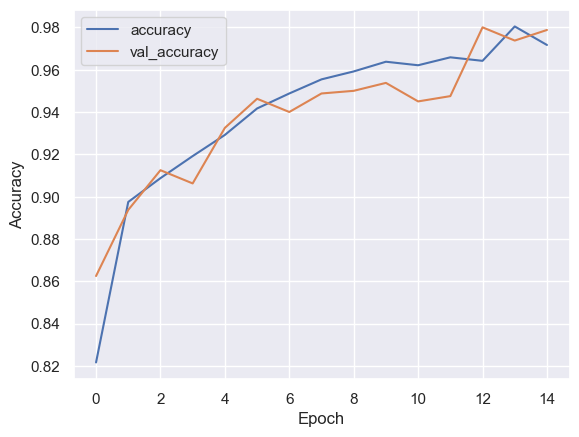

In [17]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

25/25 [==============================] - 1s 36ms/step - loss: 0.0603 - accuracy: 0.9762
Test Accuracy: 0.9762499928474426


25/25 [==============================] - 1s 30ms/step


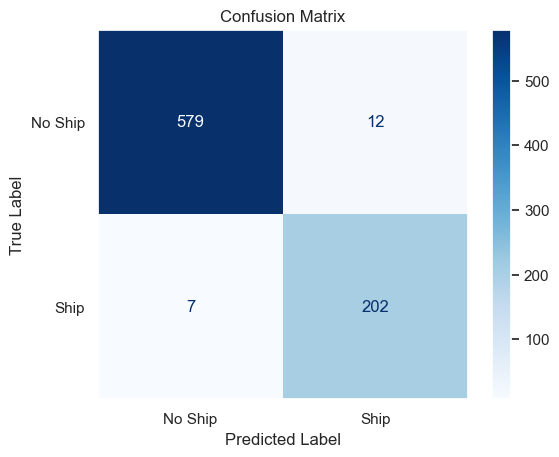

In [22]:
predictions = make_predictions(model,X_test)
plot_confusion_matrix(
    pred_labels = predictions,
    true_labels = y_test,
    title="Confusion Matrix"
)